In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from graph_nets import modules
from graph_nets import utils_np
from graph_nets import utils_tf
from graph_nets.demos_tf2 import models

import numpy as np
import pandas as pd
import sonnet as snt
import tensorflow as tf

import matplotlib.pyplot as plt

import networkx as nx

import random

In [2]:
# Reads the nodes and edge info from the csv.
def getNodesAndEdgeInfo(node_file,edge_file):
    nodes_info = pd.read_csv(node_file)
    edges_info = pd.read_csv(edge_file)

    return nodes_info, edges_info

# Constructs the graph out of the nodes and edges.
def constructGraph(nodes_info , edges_info):
    graph = nx.Graph()
    
    for index, node_info in nodes_info.iterrows():
        graph.add_node(node_info.Node)
        
    for index, edge_info in edges_info.iterrows():    
        graph.add_edge(edge_info.Sender, edge_info.Receiver)
    
    return graph

def getLabelEnumeration(labels ,label):
    unique_labels = labels.unique()
    
    return list(unique_labels).index(label)
    
# Generates the dict for the nodes in the format node_id : {node_feature , label}
def createNodeDict(nodes_info):
    nodes_dict = {}
    
    for index, node_info in nodes_info.iterrows():
        nodes_dict[node_info.Node] = {"bag_of_words" : node_info.Features , "label_name": node_info.Label, 
                                      "label_value": getLabelEnumeration(nodes_info.Label,node_info.Label)}
    
    return nodes_dict


# Checks if two nodes have same category or labels.
def checkSameCategory(node_1 , node_2 , nodes_dict):
    return nodes_dict[node_1]["label_name"] == nodes_dict[node_2]["label_name"]
    

# Adds feature to the graph.
def getFeatureAddedGraph(graph , nodes_dict , edges_info):
    for node in nodes_dict:
        graph.add_node(node , bag_of_words = nodes_dict[node]["bag_of_words"] , 
                       label_name = nodes_dict[node]["label_name"],label_value = nodes_dict[node]["label_value"])
        
    for index, edge_info in edges_info.iterrows():
        if(edge_info.Sender in nodes_dict and edge_info.Receiver in nodes_dict):
            graph.add_edge(edge_info.Sender, edge_info.Receiver , sender = edge_info.Sender , receiver = edge_info.Receiver,
                       same_category = checkSameCategory(edge_info.Sender , edge_info.Receiver , nodes_dict))
        
    return graph

# Samples the graph out of the main graph.
def getSampledGraphs(graph , batch_size = 10):
    subgraphs = []
    
    # Adding randomness to edges:
    for sender,receiver,edge_info in graph.edges(data = True):
        p = random.uniform(0,1)
            
        graph.add_edge(sender, receiver , 
                    same_category = edge_info["same_category"], p = p)
    
    # Randomly fetching the edges based on the randomness assigned above.
    for index in range(batch_size):
        edges = []
        p = random.uniform(0,1)
        
        for sender, receiver,edge_info in graph.edges(data= True):
            if edge_info['p'] < (p + .005) and edge_info['p'] > (p - .005):
                edges.append((sender,receiver))
        
        subgraph = graph.edge_subgraph(edges)
        
        subgraphs.append(subgraph)
        
    return subgraphs


In [3]:
def buildGraphFrom(node_file, edge_file): 
    nodes_info , edges_info = getNodesAndEdgeInfo(node_file,edge_file)
    graph = constructGraph(nodes_info , edges_info)
    nodes_dict = createNodeDict(nodes_info)
    feature_added_graph = getFeatureAddedGraph(graph , nodes_dict , edges_info)
    
    return feature_added_graph

def generateTrainingAndTestingSet(graph, total_batches=100, batch_sample_size = 5):
    graph_collection = []
    
    for batch_number in range(total_batches):
        subgraphs = getSampledGraphs(graph, batch_sample_size)
        graph_collection.append(subgraphs)
    
    split_index = int(0.8 * len(graph_collection))
    training_batches = graph_collection[0: split_index]
    testing_batches = graph_collection[split_index : len(graph_collection)]
    
    return training_batches , testing_batches


In [4]:
# Creates the vector for the features.
def create_feature(attr, fields):
    return np.hstack([np.array(attr[field], dtype=float) for field in fields])

# Converts the value to one_hot vector.
def to_one_hot(indices, max_value, axis=-1):
  one_hot = np.eye(max_value)[indices]
  if axis not in (-1, one_hot.ndim):
    one_hot = np.moveaxis(one_hot, -1, axis)
  return one_hot

# Gives the index of the node with a given id.
def getIndexFromId(id, nodes):
    index = 0
    
    for node_index , node_feature in nodes:
        if(node_feature['node_id'] == id):
            index = node_index
            break
    
    return index

# Splits a graph into input and output graph.
def extractInputAndOutputGraph(all_graphs):
    input_node_fields = ["bag_of_words"]
    input_edge_fields = ["sender", "receiver"]
    target_node_fields = ["label_value"]
    target_edge_fields = ["same_category"]

    input_graphs = []
    target_graphs = []

    for graph_index, graph in enumerate(all_graphs):
        input_graph = nx.Graph()
        target_graph = nx.Graph()

        for node_index, (node_id, node_feature) in enumerate(graph.nodes(data= True)):
            input_graph.add_node(node_index, node_id = node_id, features = np.array(node_feature['bag_of_words'].strip('][').split(', '), dtype=float))
            
            target_node = to_one_hot(
        create_feature(node_feature, target_node_fields).astype(int), 7)[0]
            
            target_graph.add_node(node_index, features = target_node )
        
        for sender,receiver, edge_feature in graph.edges(data= True):
            sender_index = getIndexFromId(sender , input_graph.nodes(data= True))
            receiver_index = getIndexFromId(receiver, input_graph.nodes(data = True))
            
            input_graph.add_edge(sender_index,receiver_index, features = create_feature(edge_feature, input_edge_fields))
                
            target_edge = to_one_hot(
        create_feature(edge_feature, target_edge_fields).astype(int), 2)[0]
                
            target_graph.add_edge(sender_index,receiver_index, features = target_edge)
        
        input_graph.graph["features"] = np.array([0.0])
        target_graph.graph["features"] = np.array([0.0])
        
        input_graphs.append(input_graph)
        target_graphs.append(target_graph)
        
    return input_graphs, target_graphs
    

#Converting the networkx graph to the tuple.
def networkxs_to_tf_graphs_tuple(graphs,
                              node_shape_hint=None,
                              edge_shape_hint=None,
                              data_type_hint=np.float32):
  data_dicts = []
  try:
    for graph in graphs:
      data_dict = utils_np.networkx_to_data_dict(graph, 
           node_shape_hint,edge_shape_hint, data_type_hint)
    
      data_dicts.append(data_dict)
        
  except TypeError:
    raise ValueError("Could not convert some elements of `graph_nxs`. "
                     "Did you pass an iterable of networkx instances?")

  return utils_tf.data_dicts_to_graphs_tuple(data_dicts)

#Generates the graph tuples.
def generateGraphTuples(sample_graphs):
    # Setting up input and target graph sets.
    input_graphs, output_graphs = extractInputAndOutputGraph(sample_graphs)

    # Changing the input and target graphs to the graph tuple.
    input_ph = networkxs_to_tf_graphs_tuple(input_graphs)
    target_ph = networkxs_to_tf_graphs_tuple(output_graphs)
    
    return input_ph , target_ph

def create_loss_ops(target_op, output_ops):
  loss_ops = [
      tf.compat.v1.losses.softmax_cross_entropy(target_op.nodes, output_op.nodes) +
      tf.compat.v1.losses.softmax_cross_entropy(target_op.edges,output_op.edges)
      for output_op in output_ops
  ]
  return loss_ops

def trainModelAndGetLosses(model,optimizer,training_examples, layers_count = 10):
    losses = []
    
    for index,sample_graphs in enumerate(training_examples):
        input_graphs_ph , target_graphs_ph = generateGraphTuples(sample_graphs)
        params = None
        
        with tf.GradientTape() as tape:
            output_ph_tr = model(input_graphs_ph, layers_count)
            
            loss_tr = create_loss_ops(target_graphs_ph,output_ph_tr)
            loss_tr = tf.math.reduce_sum(loss_tr) / layers_count
            
        gradients = tape.gradient(loss_tr, model.trainable_variables)
        optimizer.apply(gradients, model.trainable_variables)
        
        losses.append(loss_tr.numpy())
     
    return losses
        

In [5]:
# Extracts the labels from the output.
def getSolutionInfo(actual_outputs , obtained_outputs):
    correct_solution = 0
    
    actual_labels = []
    obtained_labels = []
    
    for index , result in enumerate(obtained_outputs):
        obtained_label = np.argmax(result)
        actual_label = np.argmax(actual_outputs[index])
        
        actual_labels.append(actual_label)
        obtained_labels.append(obtained_label)
        
        if obtained_label == actual_label:
            correct_solution+= 1
    
    return correct_solution , len(actual_outputs), obtained_labels , actual_labels

# Computes the accuracy of the model.    
def computeAccuracy(target, output, use_nodes = True , use_edges = True):
  if not use_nodes and not use_edges:
    raise ValueError("Nodes or edges (or both) must be used")

  graphs_in_touple= target.globals.shape[0]

  nodes_accuracy = []
  edges_accuracy = []
    
  for index in range(graphs_in_touple):
    
    node_solution , total_nodes, obtained_node_labels , actual_node_labels = getSolutionInfo(utils_tf.get_graph(target, index).nodes.numpy(),
                                  utils_tf.get_graph(output, index).nodes.numpy())
    
    edge_solution , total_edges, obtained_edge_labels, actual_edge_labels = getSolutionInfo(utils_tf.get_graph(target, index).edges.numpy(),
                                  utils_tf.get_graph(output, index).edges.numpy())
    
    nodes_accuracy.append({'total': total_nodes , 'correct' : node_solution , 'accurcy': node_solution/ total_nodes})
    edges_accuracy.append({'total': total_edges , 'correct' : edge_solution , 'accurcy': edge_solution/ total_edges})
    
  return nodes_accuracy, edges_accuracy

# Calculates the accuracy thorugh out the given examples.
def getCompleteModelAccuracy(batch_accuracies):
    total_correct = 0
    total_examples = 0
    
    for batch in batch_accuracies:
        for sample_accuracy in batch:
            total_correct += sample_accuracy['correct']
            total_examples += sample_accuracy['total']
    
    return total_correct / total_examples , total_correct, total_examples

# Testing the model.
def testModel(model, examples, layers_count):
    batch_node_accuracies = []
    batch_edge_accuracies = []
    
    for index,sample_graphs in enumerate(examples):
        input_graphs_ph , target_graphs_ph = generateGraphTuples(sample_graphs)
        
        output = model(input_graphs_ph, layers_count)
        test_output = output[-1]
        
        node_accuracies , edge_accuracies = computeAccuracy(target_graphs_ph , test_output)
        
        batch_node_accuracies.append(node_accuracies)
        batch_edge_accuracies.append(edge_accuracies)
    
    node_accuracy_final, node_correct_count , node_total_count = getCompleteModelAccuracy(batch_node_accuracies)
    edge_accuracy_final , edge_correct_count, edge_total_count = getCompleteModelAccuracy(batch_edge_accuracies)
        
    return {'node': {'total_correct':node_correct_count , 'total_count': node_total_count , 
                   'final_accuracy': node_accuracy_final, 'batch_accuracy' : batch_node_accuracies},
            'edge' : {'total_correct':edge_correct_count , 'total_count': edge_total_count , 
                   'final_accuracy': edge_accuracy_final, 'batch_accuracy' : batch_edge_accuracies}}
    

In [6]:
def plotLayersTestsModel(training_examples , testing_examples , layers_itr = 5 ,learning_rate = 1e-2):
    layer_specific_node_accuracies = []
    layer_specific_edge_accuracies = []
    
    for index in range(layers_itr):
        model = None
        optimizer = None
        
        model = models.EncodeProcessDecode(edge_output_size = 2, node_output_size = 7)
        optimizer = snt.optimizers.Adam(learning_rate)
                
        # Train the model.
        training_losses = trainModelAndGetLosses(model,optimizer,training_examples, index+1)

        y = training_losses
        x = [index+1 for index in range(len(training_losses))]
        
        # Plotting the training loss in each batch.
        fig, ax = plt.subplots(figsize=(5, 2.7), layout='constrained')
        ax.plot(x, y, label='Batch Loss')  # Plot some data on the axes.
        ax.set_xlabel('Batch Number')  # Add an x-label to the axes.
        ax.set_ylabel('Loss')  # Add a y-label to the axes.
        ax.set_title("Batch Loss Plot : Layer Count = {}".format(index+1))  # Add a title to the axes.
        ax.legend();  # Add a legend.
        

        # Test the model
        performance_info = testModel(model , testing_examples, index+1)
        
        layer_specific_node_accuracies.append(performance_info['node']['final_accuracy'])
        layer_specific_edge_accuracies.append(performance_info['edge']['final_accuracy'])
        
    # Plot the final node and edges accuracies based on the layers.
    node_y = layer_specific_node_accuracies
    node_x = [index+1 for index in range(len(layer_specific_node_accuracies))]
    
    edge_y = layer_specific_edge_accuracies
    edge_x = [index+1 for index in range(len(layer_specific_edge_accuracies))]
        
    fig, ax = plt.subplots(figsize=(7, 3.7), layout='constrained')
    
    ax.plot(node_x, node_y, label='Node Accuracy')  # Plot some data on the axes.
    ax.plot(edge_x, edge_y, label='Edge Accuracy')  # Plot some data on the axes.
    
    ax.set_xlabel('Layer Count')  # Add an x-label to the axes.
    ax.set_ylabel('Accuracy')  # Add a y-label to the axes.
    ax.set_title("Model Accuracy vs Layer Count")  # Add a title to the axes.
    
    ax.legend();  # Add a legend.
    

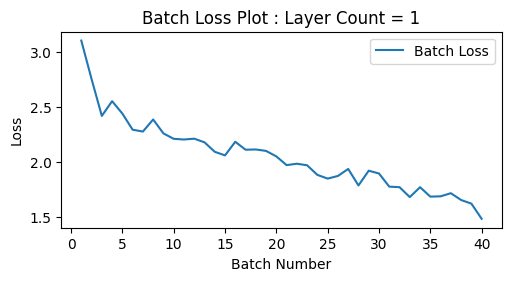

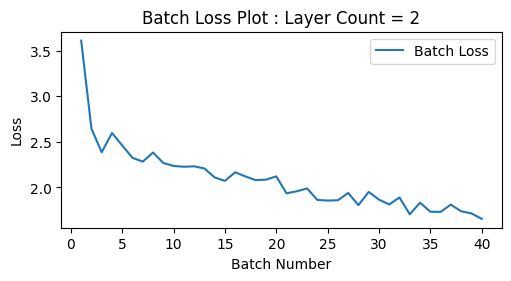

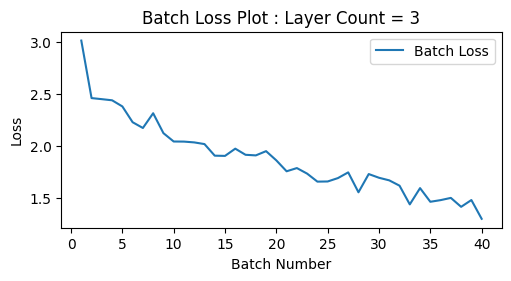

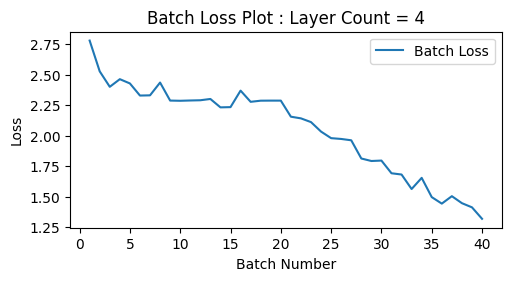

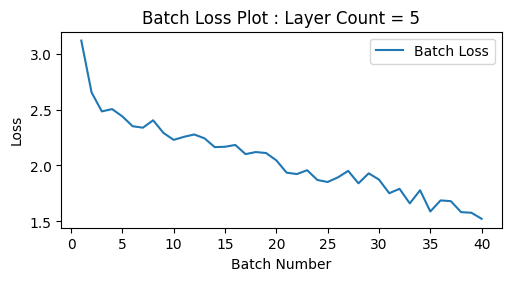

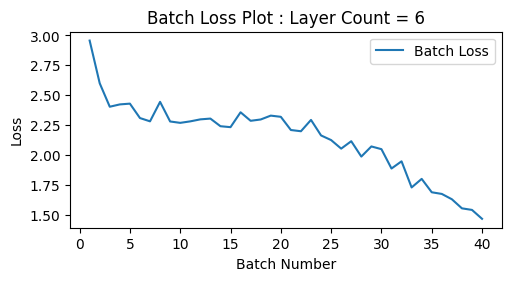

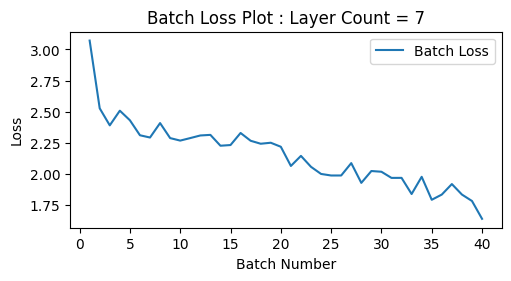

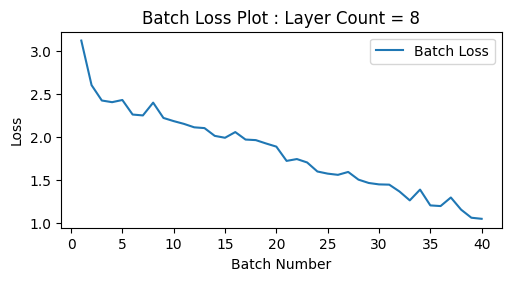

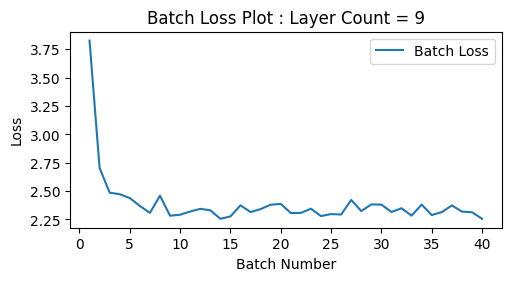

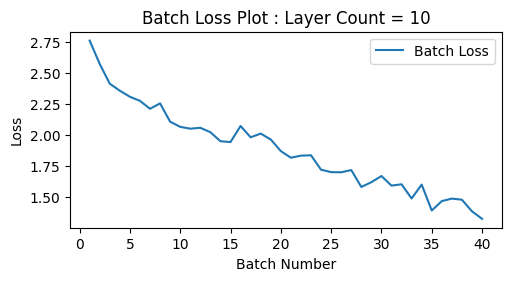

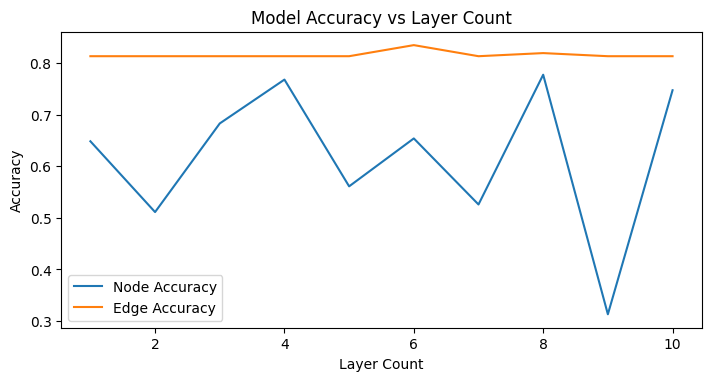

In [7]:
# Dataset setup.
graph = buildGraphFrom("cora_nodes.csv", "cora_edges.csv")
training_examples , testing_examples = generateTrainingAndTestingSet(graph, 50,5)

plotLayersTestsModel(training_examples, testing_examples,10)


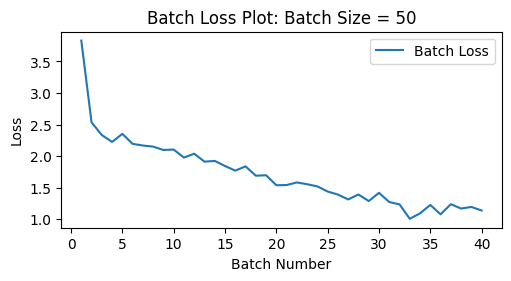

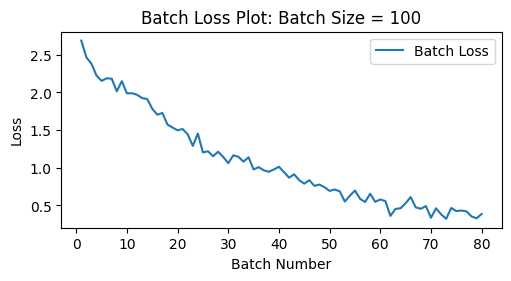

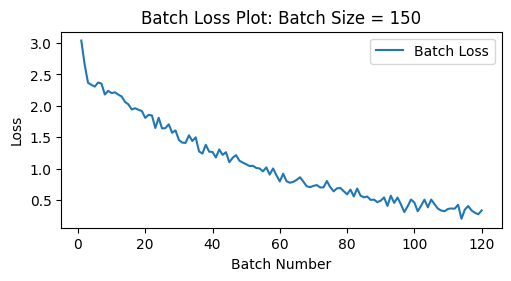

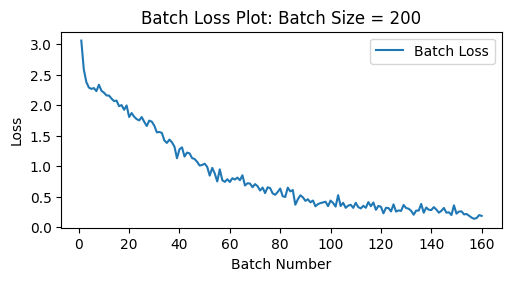

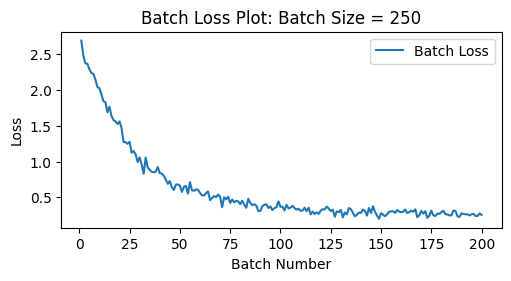

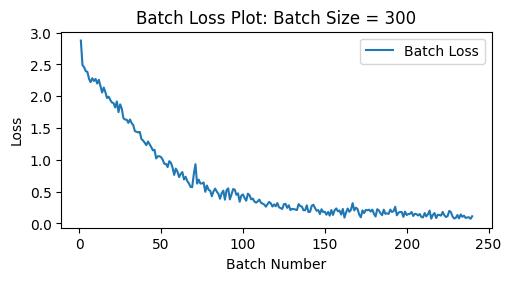

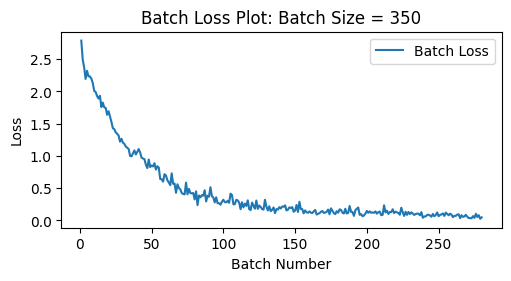

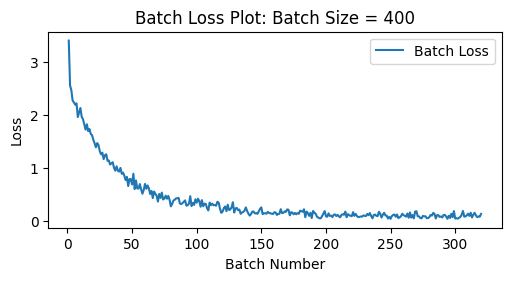

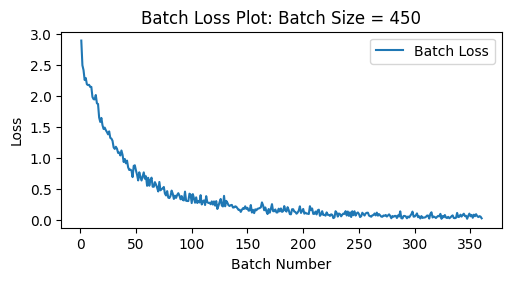

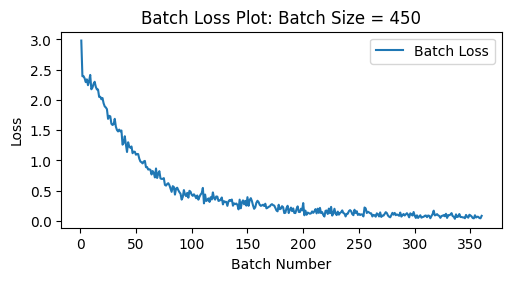

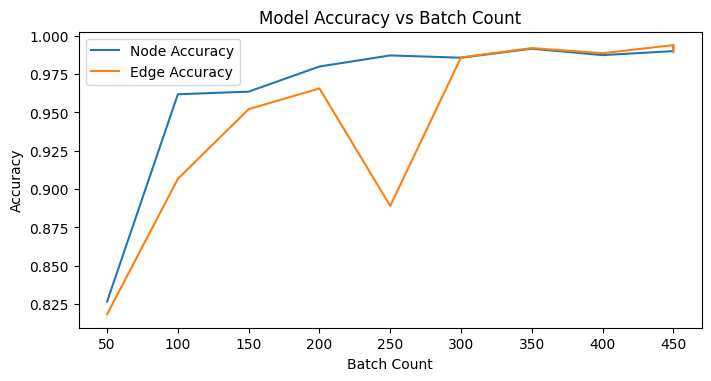

In [8]:
def plotBatchTestsModel(graph , batch_count_list , layer_count = 1 , sample_size = 5 , learning_rate = 1e-2):
    batch_specific_node_accuracies = []
    batch_specific_edge_accuracies = []
    
    for batch_count in batch_count_list:
        training_examples , testing_examples = generateTrainingAndTestingSet(graph,batch_count, sample_size)
        
        model = models.EncodeProcessDecode(edge_output_size = 2, node_output_size = 7)
        optimizer = snt.optimizers.Adam(learning_rate)
                
        # Train the model.
        training_losses = trainModelAndGetLosses(model,optimizer,training_examples, layer_count)

        y = training_losses
        x = [index+1 for index in range(len(training_losses))]
        
        # Plotting the training loss in each batch.
        fig, ax = plt.subplots(figsize=(5, 2.7), layout='constrained')
        ax.plot(x, y, label='Batch Loss')  # Plot some data on the axes.
        ax.set_xlabel('Batch Number')  # Add an x-label to the axes.
        ax.set_ylabel('Loss')  # Add a y-label to the axes.
        ax.set_title("Batch Loss Plot: Batch Size = {}".format(batch_count))  # Add a title to the axes.
        ax.legend();  # Add a legend.
        

        # Test the model
        performance_info = testModel(model , testing_examples, layer_count)
        
        batch_specific_node_accuracies.append(performance_info['node']['final_accuracy'])
        batch_specific_edge_accuracies.append(performance_info['edge']['final_accuracy'])
            
    # Plot the final node and edges accuracies based on the layers.
    node_y = batch_specific_node_accuracies
    node_x = [count for count in batch_count_list]
    
    edge_y = batch_specific_edge_accuracies
    edge_x = [count for count in batch_count_list]
        
    fig, ax = plt.subplots(figsize=(7, 3.7), layout='constrained')
    
    ax.plot(node_x, node_y, label='Node Accuracy')  # Plot some data on the axes.
    ax.plot(edge_x, edge_y, label='Edge Accuracy')  # Plot some data on the axes.
    
    ax.set_xlabel('Batch Count')  # Add an x-label to the axes.
    ax.set_ylabel('Accuracy')  # Add a y-label to the axes.
    ax.set_title("Model Accuracy vs Batch Count")  # Add a title to the axes.
    
    ax.legend();  # Add a legend.

batch_count_list = [50, 100 ,150 , 200 ,250 ,300 ,350 , 400 ,450 ,450]
plotBatchTestsModel(graph, batch_count_list , 1 , 5)

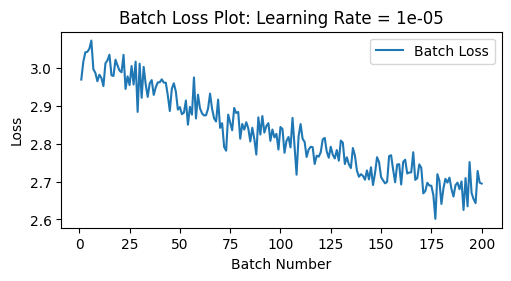

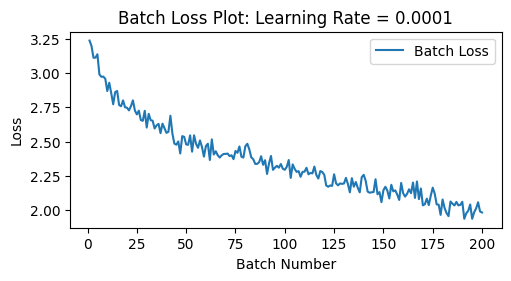

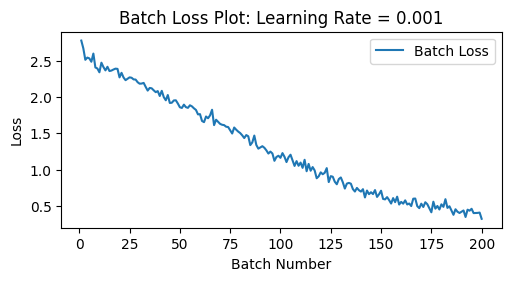

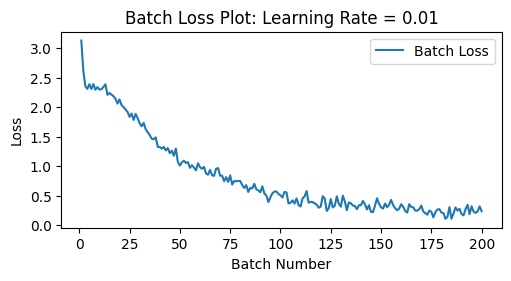

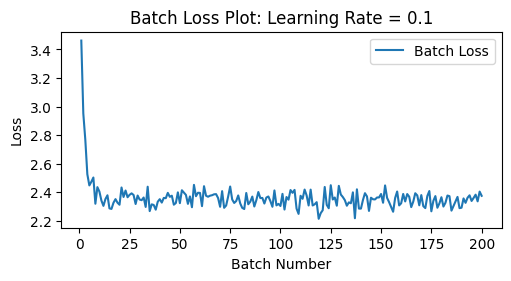

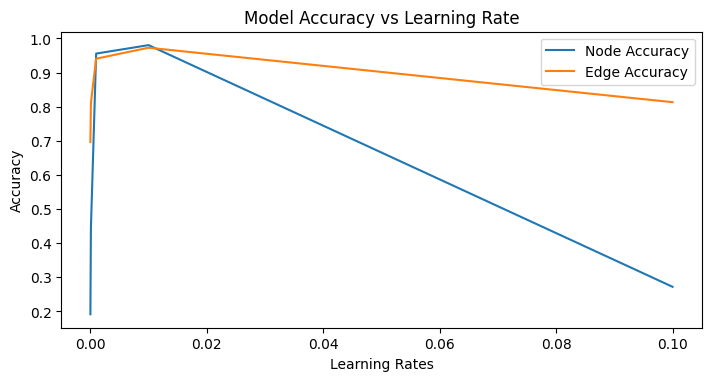

In [9]:
def plotLearningRateTestsModel(graph , learning_rates , batch_count = 100 , layer_count = 5 , sample_size = 5):
    lr_specific_node_accuracies = []
    lr_specific_edge_accuracies = []
    
    for learning_rate in learning_rates:
        training_examples , testing_examples = generateTrainingAndTestingSet(graph,batch_count, sample_size)
        
        model = models.EncodeProcessDecode(edge_output_size = 2, node_output_size = 7)
        optimizer = snt.optimizers.Adam(learning_rate)
                
        # Train the model.
        training_losses = trainModelAndGetLosses(model,optimizer,training_examples, layer_count)

        y = training_losses
        x = [index+1 for index in range(len(training_losses))]
        
        # Plotting the training loss in each batch.
        fig, ax = plt.subplots(figsize=(5, 2.7), layout='constrained')
        ax.plot(x, y, label='Batch Loss')  # Plot some data on the axes.
        ax.set_xlabel('Batch Number')  # Add an x-label to the axes.
        ax.set_ylabel('Loss')  # Add a y-label to the axes.
        ax.set_title("Batch Loss Plot: Learning Rate = {}".format(learning_rate))  # Add a title to the axes.
        ax.legend();  # Add a legend.
        

        # Test the model
        performance_info = testModel(model , testing_examples, layer_count)
        
        lr_specific_node_accuracies.append(performance_info['node']['final_accuracy'])
        lr_specific_edge_accuracies.append(performance_info['edge']['final_accuracy'])
            
    # Plot the final node and edges accuracies based on the layers.
    node_y = lr_specific_node_accuracies
    node_x = [learning_rate for learning_rate in learning_rates]
    
    edge_y = lr_specific_edge_accuracies
    edge_x = [learning_rate for learning_rate in learning_rates]
        
    fig, ax = plt.subplots(figsize=(7, 3.7), layout='constrained')
    
    ax.plot(node_x, node_y, label='Node Accuracy')  # Plot some data on the axes.
    ax.plot(edge_x, edge_y, label='Edge Accuracy')  # Plot some data on the axes.
    
    ax.set_xlabel('Learning Rates')  # Add an x-label to the axes.
    ax.set_ylabel('Accuracy')  # Add a y-label to the axes.
    ax.set_title("Model Accuracy vs Learning Rate")  # Add a title to the axes.
    
    ax.legend();  # Add a legend.

learning_rates = [1e-5,1e-4,1e-3,1e-2,1e-1]

plotLearningRateTestsModel(graph, learning_rates , 250, 5 , 5)